In [1]:
'''
************************************************
** COL774 Machine Learning
** Assignment 2
** Part B: Support Vector Machines | Fashion MNIST Classification
** @Author: Aman Bhardwaj
** @Entry No. 2019SIY7580
** @Date: 29 Feb 2020
************************************************
'''

import pandas as pd
import numpy as np
#import cvxopt
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from collections import Counter
from sklearn.svm import SVC
import time
from scipy.spatial.distance import cdist, pdist, squareform
from scipy import stats
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [2]:
votesTest = {}
votesVal = {}
votesTest_sk = {}
votesVal_sk = {}
votesTest_KF = {}
votesVal_KF = {}
oVoLearnTime = []
KFold_Train = {}
KFold_Test = {}
AccuraciesKF = {}
testAccuracies_KF = {}

In [4]:
def processData(df):
    colList = []
    for i in range(784):
        colList.append("Pxl"+str(i))
    colList.append("label")
    
    df.columns = colList
    for (c_name, c_data) in df.iteritems():
        if(c_name != "label"):
            df[c_name] = (c_data/255)
    return df

FMnistTrain = pd.read_csv("train.csv")

FMnistTrain = processData(FMnistTrain)

entryNo = 7

FTrain0 = FMnistTrain[FMnistTrain["label"] == entryNo]
FTrain1 = FMnistTrain[FMnistTrain["label"] == entryNo + 1]

FTrain0.label = -1
FTrain1.label = 1
binaryDTrain = pd.concat([FTrain0, FTrain1])

FMnistVal = pd.read_csv("val.csv")
FMnistVal = processData(FMnistVal)

    
FVal0 = FMnistVal[FMnistVal["label"] == entryNo]
FVal1 = FMnistVal[FMnistVal["label"] == entryNo + 1]


FVal0.label = -1
FVal1.label = 1
binaryDVal = pd.concat([FVal0, FVal1])

FMnistTest = pd.read_csv("test.csv")
FMnistTest = processData(FMnistTest)
    
FTest0 = FMnistTest[FMnistTest["label"] == entryNo]
FTest1 = FMnistTest[FMnistTest["label"] == entryNo + 1]

FTest0.label = -1
FTest1.label = 1
binaryDTest = pd.concat([FTest0, FTest1])

In [4]:
def linearKernel(W):
    return np.dot(W, W.T)

def gaussianKernel(x, g):
    #print("\nCalculating gaussian kernel matrix...")
    cDists = cdist(x, x,'sqeuclidean')
    KMat = np.exp(-g * cDists)
    #print("Calculation Complete.")
    #print("KMAT SIZE", KMat.shape)
    return KMat

def fitBinaryClassifierSVM(ftMat, labels, kernelType):
    rows, cols = ftMat.shape
    C = 1.0
    t0 = time.time()
    if kernelType == "linear":
        W = ftMat * labels
        #print(ftMat.shape, labels.shape, W.shape)
        H = linearKernel(W)
    elif kernelType == "gaussian":
        K = gaussianKernel(ftMat, 0.05)
        labelsMat = np.outer(labels, labels)
        H = K * labelsMat
    else:
        print("Error: Specify correct Kernel Type")
        return
    ident = np.eye(rows)
    vStack = np.vstack((ident*(-1),ident))
    G = cvxopt_matrix(vStack)
    P = cvxopt_matrix(H)
    onesArr = np.ones((rows, 1))
    q = cvxopt_matrix(-onesArr)
    zerosArr = np.zeros(rows)

    h = cvxopt_matrix(np.hstack((np.zeros(rows), np.ones(rows) * C)))

    A = cvxopt_matrix(labels.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    cvxopt_solvers.options['show_progress'] = False
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    t1 = time.time()
    oVoLearnTime.append(round(t1-t0, 3))
    print("{} kernel learning time = {}s".format(kernelType, round(t1-t0, 3)))
    #print(sol)
    return sol, H

def calcParameters(ftMat, labels, sol, th):
    solX = sol['x']
    alphaValues = np.array(solX)
    
    boolArr = (alphaValues > th).flatten()
    w = ((labels[boolArr] * alphaValues[boolArr]).T @ ftMat[boolArr]).reshape(-1,1)
    #b = labels[boolArr] - np.dot(ftMat[boolArr], w)
    #b = np.mean(b)
    #print(b)
    print("\nTotal Number of support vectors=", Counter(boolArr)[True])   
    posClass = (labels > 0).flatten()
    negClass = (labels < 0).flatten()
    
    dispPos = np.logical_and(boolArr, posClass)
    dispNeg = np.logical_and(boolArr, negClass)
    print("\nNumber of support vectors for Class 1 =",Counter(dispPos)[True],
          "\nNumber of support vectors for Class -1 =",Counter(dispNeg)[True])
    
    b = -0.5*(max(np.dot(ftMat[dispNeg], w)) +  min(np.dot(ftMat[dispPos], w)))
    return alphaValues, w, b

def getAccuracy(data, lbl, w, b):
    predict = np.dot(data, w) + b
    prediction = []
    for i in range(len(predict)):
        if predict[i] >= 0:
            if lbl[i] == 1:
                prediction.append("R")
            else:
                prediction.append("W")
        else:
            if lbl[i] == -1:
                prediction.append("R")
            else:
                prediction.append("W")    
    counter = Counter(prediction)
    accuracy = (counter["R"]/len(prediction))*100
    return accuracy

def predictGaussianSVM(x, labels, x_dash, y_dash, sol, th, YK):
    solX = sol['x']
    alphaValues = np.array(solX)
    
    boolArr = (alphaValues > th).flatten()
    posClass = (labels > 0).flatten()
    negClass = (labels < 0).flatten()
    #print(Counter(boolArr))
    dispPos = np.logical_and(boolArr, posClass)
    dispNeg = np.logical_and(boolArr, negClass)
    print("\nNumber of support vectors for Class -1 =",Counter(dispNeg)[True],
          "\nNumber of support vectors for Class 1 =",Counter(dispPos)[True])
    
    b = -0.5*(max((alphaValues[dispNeg].T @ YK[dispNeg])[0]) +  min((alphaValues[dispPos].T @ YK[dispPos])[0]))
    #print("b =", b)
    
    KMat = np.exp(-0.05 * cdist(x, x_dash,'sqeuclidean'))
    
    hypo = np.dot((labels * alphaValues).T, KMat) + b
    hypo = hypo[0]
    #print(hypo)
    
    predict = []
    prediction = []
    for i in range(len(hypo)):
        if hypo[i] > 0:
            predict.append(1)
        else:
            predict.append(-1)
            
    for i in range(len(predict)):
        if predict[i] == y_dash[i]:
            prediction.append(True)
        else:
            prediction.append(False)
    
    accuracy = (Counter(prediction)[True]/len(prediction))*100
    #print(accuracy)
        
    return accuracy, b

    
def sklearnLinearKernel(ftMat, lbl):
    t0 = time.time()
    model = SVC(C = 1.0, kernel = "linear")
    model.fit(ftMat, lbl.ravel())
    t1 = time.time()
    print("SK Learn linear kernel learning time = {}s".format(round(t1-t0, 3)))
    print('Number of support vectors for each class = ', model.n_support_)
    return model, model.coef_ , model.intercept_

def skPredict(model, data, lbl):
    
    predict = model.predict(data)
    
    prediction = []
    for i in range(len(predict)):
        if predict[i] == lbl[i]:
            prediction.append("R")
        else:
            prediction.append("W")
            
    counter = Counter(prediction)
    accuracy = (counter["R"]/len(prediction))*100
    return accuracy

def sklearnGaussianKernel(ftMat, lbl):
    t0 = time.time()
    model = SVC(C = 1.0, kernel = "rbf", gamma=0.05)
    model.fit(ftMat, lbl.ravel())
    t1 = time.time()
    oVoLearnTime.append(round(t1-t0, 3))
    print("SK Learn gaussian kernel learning time = {}s".format(round(t1-t0, 3)))
    print('Number of support vectors for each class = ', model.n_support_)
    return model


'''@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@-----ONE VS ONE-----@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@'''

def initVotesDict():
    for i in range(len(FMnistTest)):
        votesTest[i] = []
        
    for j in range(len(FMnistVal)):
        votesVal[j] = []
        
    return

def initVotesDict_sk():
    for i in range(len(FMnistTest)):
        votesTest_sk[i] = []
        
    for j in range(len(FMnistVal)):
        votesVal_sk[j] = []
    return

def calcGroups(n):
    groups = {}
    count = 0
    for i in range(n-1):
        for j in range(i+1, n):
            groups[count] = [i, j]
            count += 1
       
    return groups

def predicOVO(x, labels, x_dash, y_dash, sol, th, YK, grp):
    solX = sol['x']
    alphaValues = np.array(solX)
    
    boolArr = (alphaValues > th).flatten()
    posClass = (labels > 0).flatten()
    negClass = (labels < 0).flatten()
    dispPos = np.logical_and(boolArr, posClass)
    dispNeg = np.logical_and(boolArr, negClass)
    print(dispPos)
    print(dispNeg)
    b = -0.5*(max((alphaValues[dispNeg].T @ YK[dispNeg])[0]) +  min((alphaValues[dispPos].T @ YK[dispPos])[0]))
    print(b)
    KMat = np.exp(-0.05 * cdist(x, x_dash,'sqeuclidean'))
    
    hypo = np.dot((labels * alphaValues).T, KMat) + b
    predict = hypo[0]
    
    prediction = []
    for i in range(len(predict)):
        if predict[i] >= 0:
            prediction.append(grp[1])
        else:  
            prediction.append(grp[0])
    print(prediction)        
    return prediction

def predicOVO_SK(model, data, lbl, grp):
    predict = model.predict(data)
    
    prediction = []
    for i in range(len(predict)):
        if predict[i] == 1:
            prediction.append(grp[1])
        else:
            prediction.append(grp[0])
            
    return prediction

def updateVotes(dfFiltered, predList, dset):
    idx = 0
    #print(dfFiltered.shape, len(predList))
    if dset == "test":
        for i, row in dfFiltered.iterrows():
            votesTest[i].append(predList[idx])
            idx += 1
    elif dset == "val":
        for i, row in dfFiltered.iterrows():
            votesVal[i].append(predList[idx])
            idx += 1
    elif dset == "test_sk":
        for i, row in dfFiltered.iterrows():
            votesTest_sk[i].append(predList[idx])
            idx += 1
    elif dset == "val_sk":
        for i, row in dfFiltered.iterrows():
            votesVal_sk[i].append(predList[idx])
            idx += 1
    else:
        print("updates either test or val set only")
        
    return    

def predictAndUpdate(x, labels, sol, th, YK, grp):
    negClass = grp[0]
    posClass = grp[1]
    
    DVal_np = FMnistVal.to_numpy()
    Y_Val = DVal_np[:, -1].reshape(len(DVal_np), 1)
    X_Val = DVal_np[:, 0:-1]
    
    DTest_np = FMnistTest.to_numpy()
    Y_Test = DTest_np[:, -1].reshape(len(DTest_np), 1)
    X_Test = DTest_np[:, 0:-1]
    
    predictVal = predicOVO(x, labels, X_Val, Y_Val, sol, th, YK, grp)
    predictTest = predicOVO(x, labels, X_Test, Y_Test, sol, th, YK, grp)
    
    updateVotes(FMnistVal, predictVal, "val")
    updateVotes(FMnistTest, predictTest, "test")

    return

def predictAndUpdateSK(model, grp):
    negClass = grp[0]
    posClass = grp[1]
    
    DVal_np = FMnistVal.to_numpy()
    Y_Val = DVal_np[:, -1].reshape(len(DVal_np), 1)
    X_Val = DVal_np[:, 0:-1]
    
    DTest_np = FMnistTest.to_numpy()
    Y_Test = DTest_np[:, -1].reshape(len(DTest_np), 1)
    X_Test = DTest_np[:, 0:-1]
    
    predictVal = predicOVO_SK(model, X_Val, Y_Val, grp)
    predictTest = predicOVO_SK(model, X_Test, Y_Test, grp)
    
    updateVotes(FMnistVal, predictVal, "val_sk")
    updateVotes(FMnistTest, predictTest, "test_sk")
    
    return

                
def oneVsOne(grp, version):
    negClass = grp[0]
    posClass = grp[1]
    
    FTrainNeg = FMnistTrain[FMnistTrain["label"] == negClass]
    FTrainPos = FMnistTrain[FMnistTrain["label"] == posClass]
    
    FTrainNeg.label = -1
    FTrainPos.label = 1
    
    DTrain_ovo = pd.concat([FTrainNeg, FTrainPos])
    #DTrain
    Y = DTrain_ovo.to_numpy()[:, -1].reshape(len(DTrain_ovo), 1)
    X = DTrain_ovo.to_numpy()[:, 0: -1]
    print(Y[:100])
    if version == "cvxopt":
        solution, H = fitBinaryClassifierSVM(X, Y, "gaussian")
        predictAndUpdate(X, Y, solution, 0.01, H, grp)
    elif version == "sklearn":
        model = sklearnGaussianKernel(X, Y)
        predictAndUpdateSK(model, grp)
    return
        
def runOneVsOneClassifier(n, version):
    oVoLearnTime.clear()
    t0 = time.time()
    grps = calcGroups(n)
    #print(grps)
    for key in grps:
        print("grp =", grps[key])
        oneVsOne(grps[key], version)
    t1 = time.time()
    
    t = 0.0
    for i in range(len(oVoLearnTime)):
        t += oVoLearnTime[i]
        
    print("\nTraining Time One Vs One for {} Classes is {} Sec".format(n, t))
    print("Total Time One Vs One Training and Prediction for {} Classes is {} Sec".format(n, round(t1-t0, 3)))
    return

def findMode(arr):
    arr.sort(reverse = True)
    return stats.mode(arr).mode[0]


def calcVotingResults(dataDict):
    votingResultsVal = []
    for i in dataDict:
        votingResultsVal.append(findMode(dataDict[i]))
    return votingResultsVal

def votingResultsVsLabels(vResults, labels):
    finalResults = []
    for i in range(len(labels)):
        if vResults[i] == labels[i]:
            finalResults.append(True)
        else: 
            finalResults.append(False)
    countResults = Counter(finalResults)
    accuracy = (countResults[True]/len(labels))*100
    return accuracy

def drawConfusionMatrix(lbl, predictLbl, optmType, dSet):
    lbl_List = [0,1,2,3,4,5,6,7,8,9]
    cm = confusion_matrix(lbl, predictLbl, labels = lbl_List)
    cm_df = pd.DataFrame(cm, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
    #print(cm_df)
    plt.figure(figsize = (12,8))
    akws = {'ha':'center', 'va':'center'}
    sns.heatmap(cm_df, annot=True, fmt="d", center=1, cmap="RdBu_r", annot_kws = akws)
    plt.yticks(rotation=0, fontsize="12", va="center")
    plt.xticks(rotation=0, fontsize="12", va="center")
    plt.title("{} Confusion Matrix Multiclass Classification {}".format(optmType, dSet))
    plt.show()

def plotConfusionMatrix(VotingPredictionsTest, VotingPredictionsVal, VotingPredictionsTest_sk, VotingPredictionsVal_sk):
    lbl_val = FMnistVal["label"].to_numpy()
    lbl_test = FMnistTest["label"].to_numpy()
    
    drawConfusionMatrix(lbl_val, VotingPredictionsVal, "Validation", "CVXOPT")
    drawConfusionMatrix(lbl_test, VotingPredictionsTest, "Test", "CVXOPT")
    
    drawConfusionMatrix(lbl_val, VotingPredictionsVal_sk, "Validation", "Sklearn")
    drawConfusionMatrix(lbl_test, VotingPredictionsTest_sk, "Test", "Sklearn")
    
    return


'''@@@@@@@@@@@@@@@@@@@@@@@@@@*********KFOLD VALIDATION************@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@'''

def splitKFolds(k):
    KFold_Train.clear()
    KFold_Test.clear()
    KF = KFold(n_splits = k, shuffle = True)
    re = KF.split(X_KF)
    ct = 0
    for i in re:
        KFold_Train[ct] = i[0]
        KFold_Test[ct] = i[1]
        ct +=1
    return



def calcAccuracy_KF(predict, labels):
    prediction = []
    for i in range(len(labels)):
        if predict[i] == labels[i]:
            prediction.append(True)
        else:
            prediction.append(False)
    ctr = Counter(prediction)
    acc = (ctr[True]/len(labels))*100
    return acc

def runMultiClass_KF(k, n, c):
    accuracies = []
    DTrainKF = FMnistTrain.to_numpy()
    Y_KF = DTrainKF[:, -1].reshape(len(DTrainKF), 1)
    X_KF = DTrainKF[:, 0:-1]
    
    for i in range(k):
        print("KFold =", i)
        trainData = X_KF[KFold_Train[i]]
        trainLabels = Y_KF[KFold_Train[i]]
        
        testData = X_KF[KFold_Train[i]]
        testLabels = Y_KF[KFold_Train[i]]
        
        model = SVC(C = c, kernel = "rbf", gamma=0.05, decision_function_shape = "ovo")
        model.fit(trainData, trainLabels.ravel())
        
        predict = model.predict(testData)
        accu = calcAccuracy_KF(predict, testLabels)
        accuracies.append(accu)
        print(accu)
    
    return np.mean(accuracies)
    

def implementKFoldValidation(kFold, n):
    splitKFolds(kFold)
    AccuraciesKF.clear()
    C = [1e-05, 1e-03, 1, 5, 10]
    tStart = time.time()
    for i in range(len(C)):
        print("\n $$$$ Value of C =", C[i], "\n")
        
        t0 = time.time()
        AccuraciesKF[C[i]] = runMultiClass_KF(kFold, n,  C[i])
        t1 = time.time()
        print("Time Taken for {} Fold Validation for C = {}: {}Mins".format(kFold, C[i], round((t1-t0)/60, 3)))
    tEnd = time.time()
    print("Total Time Taken for {} Fold Validation: {}Mins".format(kFold, round((tEnd-tStart)/60, 3)))
        
    return AccuraciesKF


def kFoldTestAccuracies():
    C = [10, 5, 1, 1e-03, 1e-05]
    testAccuracies_KF.clear()
    tStart = time.time()
    trainData = FMnistTrain.to_numpy()
    lbls_Train = trainData[:, -1].reshape(len(trainData), 1)
    dMat_Train = trainData[:, 0:-1]
    print(dMat_Train.shape, lbls_Train.shape)
    
    testData = FMnistTest.to_numpy()
    lbls_Test = testData[:, -1].reshape(len(testData), 1)
    dMat_Test = testData[:, 0:-1]
    for i in range(len(C)):
        print("\n $$$$ Calculating Test Accuracy for C =", C[i], "\n")
        
        t0 = time.time()
        model = SVC(C = C[i], kernel = "rbf", gamma=0.05, decision_function_shape = "ovo")
        model.fit(dMat_Train, lbls_Train.ravel())
        
        predict = model.predict(dMat_Test)
        acc = calcAccuracy_KF(predict, lbls_Test)
        testAccuracies_KF[C[i]] = acc
        print("Test Accuracy = {}%".format(round(acc, 3)))
        t1 = time.time()
        print("Time Taken for C = {}: {}Mins".format(KF, C[i], round((t1-t0)/60, 3)))
    tEnd = time.time()
    print("Total Time Taken for Test Accuracy Calculation: {}Mins".format(round((tEnd-tStart)/60, 3)))
    return testAccuracies_KF

In [1]:
DTrainKF = FMnistTrain.to_numpy()
Y_KF = DTrainKF[:, -1].reshape(len(DTrainKF), 1)
X_KF = DTrainKF[:, 0:-1]

def splitKFolds(k):
    KFold_Train.clear()
    KFold_Test.clear()
    KF = KFold(n_splits = k, shuffle = True)
    re = KF.split(X_KF)
    ct = 0
    for i in re:
        KFold_Train[ct] = i[0]
        KFold_Test[ct] = i[1]
        ct +=1


NameError: name 'FMnistTrain' is not defined

In [2]:


def calcAccuracy_KF(predict, labels):
    prediction = []
    for i in range(len(labels)):
        if predict[i] == labels[i]:
            prediction.append(True)
        else:
            prediction.append(False)
    ctr = Counter(prediction)
    acc = (ctr[True]/len(labels))*100
    return acc

def runMultiClass_KF(k, n, c):
    accuracies = []
    
    for i in range(k):
        print("KFold =", i)
        trainData = X_KF[KFold_Train[i]]
        trainLabels = Y_KF[KFold_Train[i]]
        
        testData = X_KF[KFold_Train[i]]
        testLabels = Y_KF[KFold_Train[i]]
        
        model = SVC(C = c, kernel = "rbf", gamma=0.05, decision_function_shape = "ovo")
        model.fit(trainData, trainLabels.ravel())
        
        predict = model.predict(testData)
        accu = calcAccuracy_KF(predict, testLabels)
        accuracies.append(accu)
        print(accu)
    
    return np.mean(accuracies)
    

def implementKFoldValidation(kFold, n):
    splitKFolds(kFold)
    AccuraciesKF.clear()
    C = [1e-05, 1e-03, 1, 5, 10]
    tStart = time.time()
    for i in range(len(C)):
        print("\n $$$$ Value of C =", C[i], "\n")
        
        t0 = time.time()
        AccuraciesKF[C[i]] = runMultiClass_KF(kFold, n,  C[i])
        t1 = time.time()
        print("Time Taken for {} Fold Validation for C = {}: {}Mins".format(kFold, C[i], round((t1-t0)/60, 3)))
    tEnd = time.time()
    print("Total Time Taken for {} Fold Validation: {}Mins".format(kFold, round((tEnd-tStart)/60, 3)))
        
    return AccuraciesKF


AccuKF = implementKFoldValidation(1, 2)
print(AccuKF)

NameError: name 'splitKFolds' is not defined

In [ ]:

def kFoldTestAccuracies():
    C = [10, 5, 1, 1e-03, 1e-05]
    testAccuracies_KF.clear()
    tStart = time.time()
    trainData = FMnistTrain.to_numpy()
    lbls_Train = trainData[:, -1].reshape(len(trainData), 1)
    dMat_Train = trainData[:, 0:-1]
    print(dMat_Train.shape, lbls_Train.shape)
    
    testData = FMnistTest.to_numpy()
    lbls_Test = testData[:, -1].reshape(len(testData), 1)
    dMat_Test = testData[:, 0:-1]
    for i in range(len(C)):
        print("\n $$$$ Calculating Test Accuracy for C =", C[i], "\n")
        
        t0 = time.time()
        model = SVC(C = C[i], kernel = "rbf", gamma=0.05, decision_function_shape = "ovo")
        model.fit(dMat_Train, lbls_Train.ravel())
        
        predict = model.predict(dMat_Test)
        acc = calcAccuracy_KF(predict, lbls_Test)
        testAccuracies_KF[C[i]] = acc
        print("Test Accuracy = {}%".format(round(acc, 3)))
        t1 = time.time()
        print("Time Taken for C = {}: {}Mins".format(KF, C[i], round((t1-t0)/60, 3)))
    tEnd = time.time()
    print("Total Time Taken for Test Accuracy Calculation: {}Mins".format(round((tEnd-tStart)/60, 3)))
    print(testAccuracies_KF)
    return

kFoldTestAccuracies()
        

(22499, 784) (22499, 1)

 $$$$ Calculating Test Accuracy for C = 10 

Test Accuracy = 88.238%
Time Taken for C = KFold(n_splits=5, random_state=None, shuffle=True): 10Mins

 $$$$ Calculating Test Accuracy for C = 5 



In [10]:
AccuraciesKF

{1e-05: 10.133896327573753}

In [89]:
print(10**(-5))

1e-05


In [ ]:
initVotesDict()
runOneVsOneClassifier(2, "cvxopt")
lbl_test = FMnistTest["label"].to_numpy()
print("lbl_test",lbl_test)
VotingPredictionsTest = calcVotingResults(votesTest)
TestOVO_sk = votingResultsVsLabels(VotingPredictionsTest, lbl_test)
print(TestOVO_sk)

In [ ]:
print(2 == 2.0)
print(lbl_test[1] == 1)
for n in range(1000):
    if (lbl_test[n] == 0):
        print(n, stats.mode(votesTest[n]).mode[0], lbl_test[n])
    
n=25
#print(votesTest[n])
#print(n, stats.mode(votesTest[n]).mode[0], lbl_test[n])

In [6]:
initVotesDict_sk()
runOneVsOneClassifier(2, "sklearn")

labels = FMnistTest["label"].to_numpy()      
VotingPredictionsTest_sk = calcVotingResults(votesTest_sk)
TestOVO_sk = votingResultsVsLabels(VotingPredictionsTest_sk, labels)

labels = FMnistVal["label"].to_numpy()      
VotingPredictionsVal_sk = calcVotingResults(votesVal_sk)
ValOVO_sk = votingResultsVsLabels(VotingPredictionsVal_sk, labels)

print("\n Test Accuracy OneVsOne using Sklearn =", TestOVO_sk)
print("\n Val Accuracy OneVsOne using Sklearn=", ValOVO_sk)

grp = [0, 1]
SK Learn gaussian kernel learning time = 3.277s
Number of support vectors for each class =  [546 265]

Training Time One Vs One for 2 Classes is 0.0 Sec
Total Time One Vs One Training and Prediction for 2 Classes is 8.686 Sec

 Test Accuracy OneVsOne using Sklearn = 19.76395279055811

 Val Accuracy OneVsOne using Sklearn= 19.727891156462583


In [50]:
DTrainBin = binaryDTrain.to_numpy()
Y_G = DTrainBin[:, -1].reshape(len(DTrainBin), 1)
X_G = DTrainBin[:, 0:-1]
SolutionGau, H = fitBinaryClassifierSVM(X_G, Y_G, "gaussian")

DTrainBin_Val = binaryDVal.to_numpy()
YVal_G = DTrainBin_Val[:, -1].reshape(len(DTrainBin_Val), 1)
XVal_G = DTrainBin_Val[:, 0:-1]

predictGaussianSVM(X_G, Y_G, XVal_G, YVal_G, SolutionGau, 0.01, H)

DTest_G = binaryDTest.to_numpy()
Y_Test = DTest_G[:, -1].reshape(len(DTest_G), 1)
X_Test = DTest_G[:, 0:-1]

TestAccu_G, b_G_Test = predictGaussianSVM(X_G, Y_G, X_Test, Y_Test, SolutionGau, 0.01, H)
print("Calculate b for Test Set =", b_G_Test)
print("Test Accuracy CVXOPT Gaussian Kernel = {}%".format(round(TestAccu_G, 3)))

gaussian kernel learning time = 54.749s

Number of support vectors for Class -1 = 763 
Number of support vectors for Class 1 = 441

Number of support vectors for Class -1 = 763 
Number of support vectors for Class 1 = 441
Calculate b for Test Set = -0.47460654122577894
Test Accuracy CVXOPT Gaussian Kernel = 99.8%


In [ ]:
DTrainBin = binaryDTrain.to_numpy()
Y = DTrainBin[:, -1].reshape(len(DTrainBin), 1)
X = DTrainBin[:, 0:-1]

'''@@@@@@@@@@@@@@@@@**********-----Q1_A-----**********@@@@@@@@@@@@@@@@@'''
print("\n#################\n-------Q1_A-------\n################")
SolutionLin, H = fitBinaryClassifierSVM(X, Y, "linear")
alphaValues , W, b = calcParameters(X, Y, SolutionLin, 1e-04)
print("b =", b)
DVal = binaryDVal.to_numpy()
Y_Val = DVal[:, -1].reshape(len(DVal), 1)
X_Val = DVal[:, 0:-1]

ValAccu = getAccuracy(X_Val, Y_Val, W, b)
print("Validation Accuracy CVXOPT Linear Kernel = {}%".format(round(ValAccu, 3)))

DTest = binaryDTest.to_numpy()
Y_Test = DTest[:, -1].reshape(len(DTest), 1)
X_Test = DTest[:, 0:-1]

TestAccu = getAccuracy(X_Test, Y_Test, W, b)
print("Test Accuracy CVXOPT Linear Kernel = {}%", .format(round(TestAccu, 3)))




'''@@@@@@@@@@@@@@@@@**********-----Q1_B-----**********@@@@@@@@@@@@@@@@@'''
print("\n#################\n-------Q1_B-------\n################")
SolutionGau, H = fitBinaryClassifierSVM(X, Y, "gaussian")

DVal = binaryDVal.to_numpy()
Y_Val = DVal[:, -1].reshape(len(DVal), 1)
X_Val = DVal[:, 0:-1]

ValAccu_G, b_G_Val = predictGaussianSVM(X, Y, X_Val, Y_Val, SolutionGau, 0.01, H)
print("Calculate b for Validation Set =", b_G_Val)
print("Validation Accuracy CVXOPT Gaussian Kernel = {}%".format(round(ValAccu_G, 3)))

DTest_G = binaryDTest.to_numpy()
Y_Test = DTest[:, -1].reshape(len(DTest), 1)
X_Test = DTest[:, 0:-1]

TestAccu_G, b_G_Test = predictGaussianSVM(X, Y, X_Test, Y_Test, SolutionGau, 0.01, H)
print("Calculate b for Test Set =", b_G_Test)
print("Test Accuracy CVXOPT Gaussian Kernel = {}%".format(round(TestAccu_G, 3)))


'''@@@@@@@@@@@@@@@@@**********-----Q1_C-----**********@@@@@@@@@@@@@@@@@'''
print("\n#################\n-------Q1_C-------\n################")
#linear kernel
ta = time.time()
sk_linear, W_sk, b_sk = sklearnLinearKernel(X, Y)
tb = time.time()
print("Computational Time | Linear Kernel | Sklearn = {}s".format(round(tb-ta, 3)))
print("b sklearn =", b_sk)
DVal = binaryDVal.to_numpy()
Y_Val = DVal[:, -1].reshape(len(DVal), 1)
X_Val = DVal[:, 0:-1]

ValAccu_sk = skPredict(sk_linear, X_Val, Y_Val)
print("SK Learn Validation Accuracy =", ValAccu_sk)

DTest = binaryDTest.to_numpy()
Y_Test = DTest[:, -1].reshape(len(DTest), 1)
X_Test = DTest[:, 0:-1]

TestAccu_sk = skPredict(sk_linear, X_Test, Y_Test)
print("SK Learn Test Accuracy =", TestAccu_sk)

#Gaussian (RBF) Kernel
tc = time.time()
sk_gaussian = sklearnGaussianKernel(X, Y)
td = time.time()
print("Computational Time | Gaussian Kernel | Sklearn = {}s".format(round(td-tc, 3)))
print("\nb SKlearn Gaussian =", sk_gaussian.intercept_)

DVal = binaryDVal.to_numpy()
Y_Val = DVal[:, -1].reshape(len(DVal), 1)
X_Val = DVal[:, 0:-1]

ValAccu_sk = skPredict(sk_gaussian, X_Val, Y_Val)
print("\nSK Learn Gaussian Validation Accuracy =", ValAccu_sk)

DTest = binaryDTest.to_numpy()
Y_Test = DTest[:, -1].reshape(len(DTest), 1)
X_Test = DTest[:, 0:-1]

TestAccu_sk = skPredict(sk_gaussian, X_Test, Y_Test)
print("SK Learn Gaussian Test Accuracy =", TestAccu_sk)


 
    
    
'''@@@@@@@@@@@@@@@@@**********-----Q2_A-----**********@@@@@@@@@@@@@@@@@'''
print("\n#################\n-------Q2_A-------\n################")
initVotesDict()
runOneVsOneClassifier(10, "cvxopt")

labels = FMnistTest["label"].to_numpy()      
VotingPredictionsTest = calcVotingResults(votesTest)
TestOVO = votingResultsVsLabels(VotingPredictionsTest, labels)

labels = FMnistVal["label"].to_numpy()      
VotingPredictionsVal = calcVotingResults(votesVal)
ValOVO = votingResultsVsLabels(VotingPredictionsVal, labels)

print("\n Test Accuracy OneVsOne using CVXOPT =", TestOVO)
print("\n Val Accuracy OneVsOne using CVXOPT =", ValOVO)



'''@@@@@@@@@@@@@@@@@**********-----Q2_B-----**********@@@@@@@@@@@@@@@@@'''
print("\n#################\n-------Q2_B-------\n################")
initVotesDict_sk()
runOneVsOneClassifier(10, "sklearn")

labels = FMnistTest["label"].to_numpy()      
VotingPredictionsTest_sk = calcVotingResults(votesTest_sk)
TestOVO_sk = votingResultsVsLabels(VotingPredictionsTest_sk, labels)

labels = FMnistVal["label"].to_numpy()      
VotingPredictionsVal_sk = calcVotingResults(votesVal_sk)
ValOVO_sk = votingResultsVsLabels(VotingPredictionsVal_sk, labels)

print("\n Test Accuracy OneVsOne using Sklearn =", TestOVO_sk)
print("\n Val Accuracy OneVsOne using Sklearn=", ValOVO_sk)



'''@@@@@@@@@@@@@@@@@**********-----Q2_C-----**********@@@@@@@@@@@@@@@@@'''
print("\n#################\n-------Q2_C-------\n################")
plotConfusionMatrix(VotingPredictionsTest, VotingPredictionsVal, VotingPredictionsTest_sk, VotingPredictionsVal_sk)


'''@@@@@@@@@@@@@@@@@**********-----Q2_D-----**********@@@@@@@@@@@@@@@@@'''
print("\n#################\n-------Q2_D-------\n################")


AccuKF = implementKFoldValidation(1, 2)
print("\n5 Fold Validation Accuracy values for different values of C\n",AccuKF)
kFoldTestAccuracies()

In [58]:
initVotesDict_sk()
runOneVsOneClassifier(10, "sklearn")

labels = FMnistTest["label"].to_numpy()      
VotingPredictionsTest_sk = calcVotingResults(votesTest_sk)
TestOVO_sk = votingResultsVsLabels(VotingPredictionsTest_sk, labels)

labels = FMnistVal["label"].to_numpy()      
VotingPredictionsVal_sk = calcVotingResults(votesVal_sk)
ValOVO_sk = votingResultsVsLabels(VotingPredictionsVal_sk, labels)
print("\n Test Accuracy OneVsOne =", TestOVO_sk)
print("\n Val Accuracy OVO =", ValOVO_sk)

grp = [0, 1]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.321s
Number of support vectors for each class =  [546 265]
grp = [0, 2]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 5.464s
Number of support vectors for each class =  [641 653]
grp = [0, 3]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 6.019s
Number of support vectors for each class =  [789 738]
grp = [0, 4]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 4.839s
Number of support vectors for each class =  [541 530]
grp = [0, 5]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 4.185s
Number of support vectors for each class =  [410 606]
grp = [0, 6]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 9.319s
Number of support vectors for each class =  [1175 1155]
grp = [0, 7]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 2.322s
Number of support vectors for each class =  [392 205]
grp = [0, 8]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 5.081s
Number of support vectors for each class =  [472 834]
grp = [0, 9]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.181s
Number of support vectors for each class =  [409 417]
grp = [1, 2]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.302s
Number of support vectors for each class =  [250 566]
grp = [1, 3]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.688s
Number of support vectors for each class =  [308 642]
grp = [1, 4]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 2.948s
Number of support vectors for each class =  [261 489]
grp = [1, 5]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.04s
Number of support vectors for each class =  [210 564]
grp = [1, 6]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.613s
Number of support vectors for each class =  [263 666]
grp = [1, 7]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 1.547s
Number of support vectors for each class =  [201 195]
grp = [1, 8]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.687s
Number of support vectors for each class =  [221 743]
grp = [1, 9]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 2.431s
Number of support vectors for each class =  [210 412]
grp = [2, 3]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 4.301s
Number of support vectors for each class =  [565 537]
grp = [2, 4]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 9.236s
Number of support vectors for each class =  [1168 1152]
grp = [2, 5]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 4.014s
Number of support vectors for each class =  [429 619]
grp = [2, 6]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 9.884s
Number of support vectors for each class =  [1248 1263]
grp = [2, 7]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 2.418s
Number of support vectors for each class =  [412 207]
grp = [2, 8]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 5.509s
Number of support vectors for each class =  [545 849]
grp = [2, 9]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.291s
Number of support vectors for each class =  [441 420]
grp = [3, 4]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 4.88s
Number of support vectors for each class =  [627 632]
grp = [3, 5]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.577s
Number of support vectors for each class =  [344 577]
grp = [3, 6]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 6.577s
Number of support vectors for each class =  [722 891]
grp = [3, 7]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 2.078s
Number of support vectors for each class =  [332 196]
grp = [3, 8]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 4.644s
Number of support vectors for each class =  [406 793]
grp = [3, 9]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 2.957s
Number of support vectors for each class =  [343 412]
grp = [4, 5]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.754s
Number of support vectors for each class =  [387 593]
grp = [4, 6]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 10.041s
Number of support vectors for each class =  [1134 1203]
grp = [4, 7]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 2.26s
Number of support vectors for each class =  [374 198]
grp = [4, 8]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 5.144s
Number of support vectors for each class =  [469 851]
grp = [4, 9]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.228s
Number of support vectors for each class =  [389 416]
grp = [5, 6]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 4.379s
Number of support vectors for each class =  [629 492]
grp = [5, 7]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 5.688s
Number of support vectors for each class =  [860 555]
grp = [5, 8]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 5.987s
Number of support vectors for each class =  [752 777]
grp = [5, 9]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 5.145s
Number of support vectors for each class =  [778 548]
grp = [6, 7]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 2.781s
Number of support vectors for each class =  [459 215]
grp = [6, 8]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 6.228s
Number of support vectors for each class =  [638 912]
grp = [6, 9]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 3.823s
Number of support vectors for each class =  [497 423]
grp = [7, 8]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 4.367s
Number of support vectors for each class =  [282 759]
grp = [7, 9]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 5.108s
Number of support vectors for each class =  [508 715]
grp = [8, 9]


C:\Users\Aman\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SK Learn gaussian kernel learning time = 4.98s
Number of support vectors for each class =  [787 449]
Training Time One Vs One for 10 Classes is 540.899 Sec

 Test Accuracy OVO = 88.07761552310463

 Val Accuracy OVO = 87.91516606642658


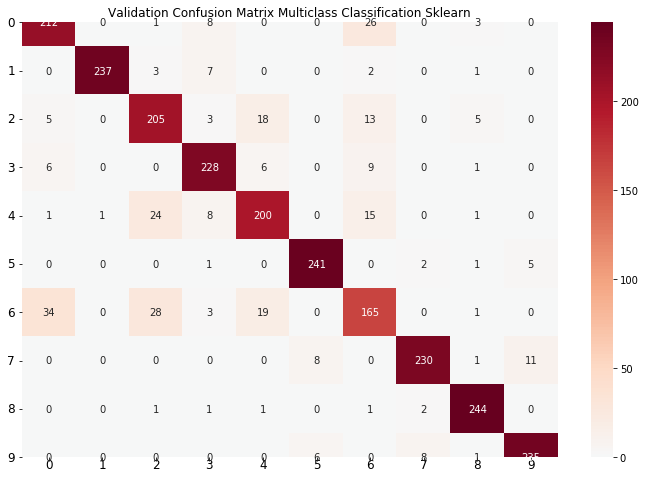

In [102]:
lbl_val = FMnistVal["label"].to_numpy()
drawConfusionMatrix(lbl_val, VotingPredictionsVal_sk, "Validation", "Sklearn")

In [80]:
len(votesTest_sk)

0

In [129]:
DTrainBin = binaryDTrain.to_numpy()
Y = DTrainBin[:, -1].reshape(len(DTrainBin), 1)
X = DTrainBin[:, 0:-1]


In [130]:
SolutionLin, H = fitBinaryClassifierSVM(X, Y, "linear")

(4500, 784) (4500, 1) (4500, 784)
linear kernel learning time = 45.525s


In [177]:
alphaValues , W, b = calcParameters(X, Y, SolutionLin, 1e-04)
print("b =", b)
DVal = binaryDVal.to_numpy()
Y_Val = DVal[:, -1].reshape(len(DVal), 1)
X_Val = DVal[:, 0:-1]

ValAccu = getAccuracy(X_Val, Y_Val, W, b)
print("Validation Accuracy =", ValAccu)

DTest = binaryDTest.to_numpy()
Y_Test = DTest[:, -1].reshape(len(DTest), 1)
X_Test = DTest[:, 0:-1]

TestAccu = getAccuracy(X_Test, Y_Test, W, b)
print("Test Accuracy =", TestAccu)



Total Number of support vectors= 198

Number of support vectors for Class 1 = 87 
Number of support vectors for Class -1 = 111
b = [-1.62821354]
Validation Accuracy = 97.39999999999999
Test Accuracy = 98.1981981981982


In [ ]:
alphaValues_G , W_G, b_G = calcParameters(X, Y, SolutionGau, 0)
print("b =", b_G)
DVal = binaryDVal.to_numpy()
Y_Val = DVal[:, -1].reshape(len(DVal), 1)
X_Val = DVal[:, 0:-1]

ValAccu_G = getAccuracy(X_Val, Y_Val, W_G, b_G)
print("Validation Accuracy =", ValAccu_G)

DTest_G = binaryDTest.to_numpy()
Y_Test = DTest[:, -1].reshape(len(DTest), 1)
X_Test = DTest[:, 0:-1]

TestAccu_G = getAccuracy(X_Test, Y_Test, W_G, b_G)
print("Test Accuracy =", TestAccu_G)


In [ ]:
sk_linear, W_sk, b_sk = sklearnLinearKernel(X, Y)
print("b sklearn =", b_sk)
DVal = binaryDVal.to_numpy()
Y_Val = DVal[:, -1].reshape(len(DVal), 1)
X_Val = DVal[:, 0:-1]

ValAccu_sk = skPredict(sk_linear, X_Val, Y_Val)
print("SK Learn Validation Accuracy =", ValAccu_sk)

DTest = binaryDTest.to_numpy()
Y_Test = DTest[:, -1].reshape(len(DTest), 1)
X_Test = DTest[:, 0:-1]

TestAccu_sk = skPredict(sk_linear, X_Test, Y_Test)
print("SK Learn Test Accuracy =", TestAccu_sk)


In [55]:
sk_gaussian = sklearnGaussianKernel(X, Y)

print("\nb SKlearn Gaussian =", sk_gaussian.intercept_)

DVal = binaryDVal.to_numpy()
Y_Val = DVal[:, -1].reshape(len(DVal), 1)
X_Val = DVal[:, 0:-1]

ValAccu_sk = skPredict(sk_gaussian, X_Val, Y_Val)
print("\nSK Learn Gaussian Validation Accuracy =", ValAccu_sk)

DTest = binaryDTest.to_numpy()
Y_Test = DTest[:, -1].reshape(len(DTest), 1)
X_Test = DTest[:, 0:-1]

TestAccu_sk = skPredict(sk_gaussian, X_Test, Y_Test)
print("SK Learn Gaussian Test Accuracy =", TestAccu_sk)

SK Learn gaussian kernel learning time = 3.174s
Number of support vectors for each class =  [546 265]

b SKlearn Gaussian = [-0.51746964]

SK Learn Gaussian Validation Accuracy = 98.6
SK Learn Gaussian Test Accuracy = 98.8988988988989


In [ ]:
import math
math.sqrt(10122750)